In [33]:
import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import emoji
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [43]:
#import data to prepare for sentiment analysis
data = pd.read_csv('data/finance_crypto/finance_crypto-train.csv')
# Select only the "tweet_text" column
data = data[["tweet_text"]]

# Display the dataframe
data.head()

,tweet_text
0,$TIA\n\nMore new highs. 🔥🔥
1,$MKR
2,"#lina $lina is wild, highly volatile\nLong onl..."
3,$SUKU\n\nExpecting more upside as long as this...
4,RT @CryptoNoanGemz: Postponed due to some issues


In [44]:
#inspect the relevant data column and look for issues
print('Dataset size:',data.shape)
#remove any rows with missing data
data = data.dropna()
data.info()
data.head()

Dataset size: (47567, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 45153 entries, 0 to 47566
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  45153 non-null  object
dtypes: object(1)
memory usage: 705.5+ KB


,tweet_text
0,$TIA\n\nMore new highs. 🔥🔥
1,$MKR
2,"#lina $lina is wild, highly volatile\nLong onl..."
3,$SUKU\n\nExpecting more upside as long as this...
4,RT @CryptoNoanGemz: Postponed due to some issues


In [46]:
def clean_tweets_column(df, column_name, cleaned_column):
    # Function to convert emojis to words using emoji library mapping
    def convert_emojis_to_words(tweet):
        converted_text = emoji.demojize(tweet)
        return converted_text
    
    def clean_tweet(tweet):
        # Convert to string if it's not already
        tweet = str(tweet)
        # Remove hyperlinks
        tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
        # Remove user @ references and '#' from hashtags
        tweet = re.sub(r'\@\w+|\#','', tweet)
        # Remove emojis
        tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
        # Remove new lines
        tweet = tweet.replace('\n', ' ')
        # Remove extra spaces
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        # Convert to lowercase
        tweet = tweet.lower()
        # Remove special characters, numbers, and punctuations
        tweet = "".join([char for char in tweet if char not in string.punctuation])
        tweet = re.sub('[0-9]+', '', tweet)
        return tweet

    def remove_stopwords(tweet):
        stop_words = set(stopwords.words('english'))
        tweet_tokens = tweet.split()
        filtered_tweet = [word for word in tweet_tokens if word not in stop_words]
        return ' '.join(filtered_tweet)

    # Apply the function to the 'text_cleaned' column in the DataFrame
    df[cleaned_column] = df[column_name].apply(convert_emojis_to_words)

    # Apply the clean_tweet function to the specified column
    df[cleaned_column] = df[column_name].astype(str).apply(clean_tweet)
    # Remove stop words
    df[cleaned_column] = df[cleaned_column].apply(remove_stopwords)

clean_tweets_column(data, 'tweet_text', 'clean_tweet_text')

In [47]:
#Convert possible chat words into full words:
#convert chatwords 
chat_words_dict = {
    "imo": "in my opinion",
    "cyaa": "see you",
    "idk": "I don't know",
    "rn": "right now",
    "afaik": "as far as I know",
    "brb": "be right back",
    "btw": "by the way",
    "cya": "see you",
    "dm": "direct message",
    "ffs": "for f*ck's sake",
    "fml": "f*ck my life",
    "ftw": "for the win",
    "hmu": "hit me up",
    "icymi": "in case you missed it",
    "idc": "I don't care",
    "idgaf": "I don't give a f*ck",
    "idts": "I don't think so",
    "iirc": "if I recall correctly",
    "ikr": "I know, right?",
    "ily": "I love you",
    "imho": "in my humble opinion"
}


def convert_chat_words(text):
    words = text.split()
    converted_words = []
    for word in words:
        if word.lower() in chat_words_dict:
            converted_words.append(chat_words_dict[word.lower()])
        else:
            converted_words.append(word)
    converted_text = " ".join(converted_words)
    return converted_text

data['clean_tweet_text'] = data['clean_tweet_text'].apply(convert_chat_words)
data

,tweet_text,clean_tweet_text
0,$TIA\n\nMore new highs. 🔥🔥,tia new highs
1,$MKR,mkr
2,"#lina $lina is wild, highly volatile\nLong onl...",lina lina wild highly volatile long confirmati...
3,$SUKU\n\nExpecting more upside as long as this...,suku expecting upside long breakout holds
4,RT @CryptoNoanGemz: Postponed due to some issues,rt postponed due issues
...,...,...
47562,"@ShardiB2 $LTC, $NEO, $EOS terrible investment",ltc neo eos terrible investment
47563,How are the $LTC maxi’s holding up?,ltc maxis holding
47564,$BITO looks like it may have found a bottom,bito looks like may found bottom
47565,$SUSHI - $9’s tagged \n\nLovely setup - easy ...,sushi tagged lovely setup easy trigger entry i...


In [48]:
# Function to apply tokens and stop word removal to a text
def tokenaise(text):
    tokens = word_tokenize(text)  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Get the stop words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return tokens
# Apply stemming to the 'tweet_text_cleaned' column
data['token_text'] = data['clean_tweet_text'].apply(tokenaise)

# Display the original and stemmed text
print("Original Text:\n", data['clean_tweet_text'])
print("\nToken Text:\n", data['token_text'])

Original Text:
 0                                            tia new highs
1                                                      mkr
2        lina lina wild highly volatile long confirmati...
3                suku expecting upside long breakout holds
4                                  rt postponed due issues
                               ...                        
47562                      ltc neo eos terrible investment
47563                                    ltc maxis holding
47564                     bito looks like may found bottom
47565    sushi tagged lovely setup easy trigger entry i...
47566                           near video guys check near
Name: clean_tweet_text, Length: 45153, dtype: object

Token Text:
 0                                        [tia, new, highs]
1                                                    [mkr]
2        [lina, lina, wild, highly, volatile, long, con...
3         [suku, expecting, upside, long, breakout, holds]
4                             [r

In [49]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# POS tag mapping dictionary
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

# Function to perform Lemmatization on a text
def lemmatize_text(tweet):
    # Get the POS tags for the words
    pos_tags = nltk.pos_tag(tweet)
    
    # Perform Lemmatization
    lemmatized_words = []
    for word, tag in pos_tags:
        # Map the POS tag to WordNet POS tag
        pos = wordnet_map.get(tag[0].upper(), wordnet.NOUN)
        # Lemmatize the word with the appropriate POS tag
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        # Add the lemmatized word to the list
        lemmatized_words.append(lemmatized_word)
    
    return lemmatized_words

# Apply Lemmatization to the 'tokens' column
data['token_text'] = data['token_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre.premstaller\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


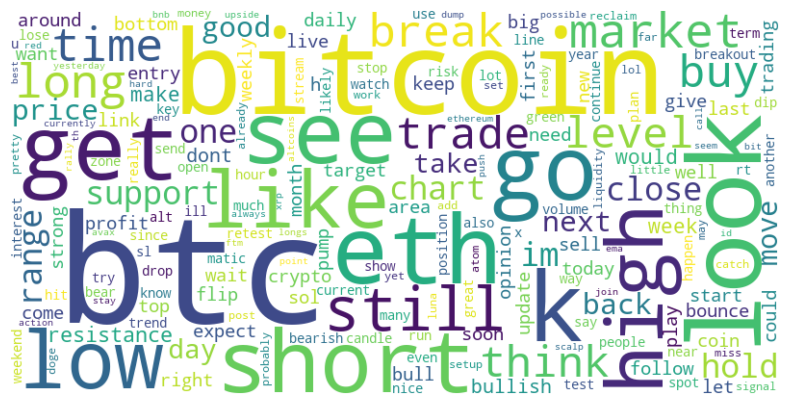

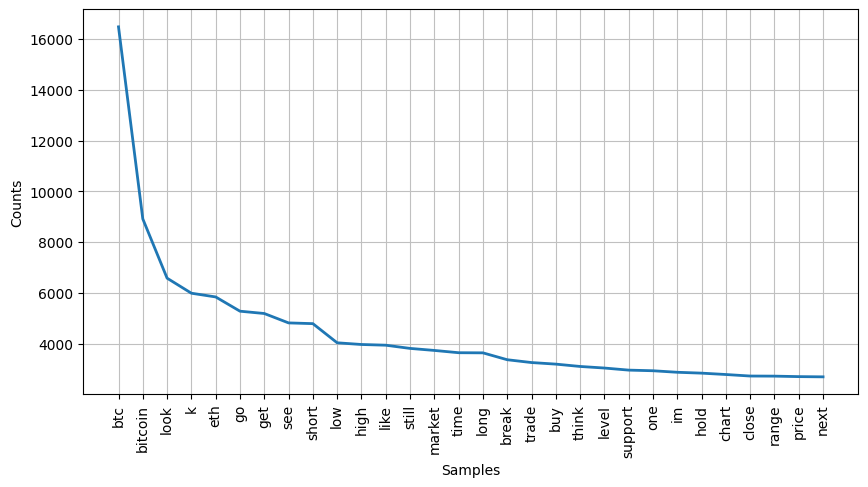

<Axes: xlabel='Samples', ylabel='Counts'>

In [50]:
from wordcloud import WordCloud
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Create a list of all tokens
all_tokens = [token for tokens_list in data['token_text'] for token in tokens_list]
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(nltk.FreqDist(all_tokens)))
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Calculate word frequency
freq_dist = FreqDist(all_tokens)
# Plot the most common words
plt.figure(figsize=(10, 5))
freq_dist.plot(30, cumulative=False)

In [51]:
#create new csv file with cleaned data
data.to_csv('data/finance_crypto/finance_crypto-train-cleaned.csv', index=False)

# Continue with feature extraction